# Arabic Character Recognition

## Dataset
The data-set is composed of 16,800 characters written by 60 participants, the age range is between 19 to 40 years, and 90% of participants are right-hand. Each participant wrote each character (from ’alif’ to ’ya’). The forms were scanned at the resolution of 300 dpi. Each block is segmented automatically using Matlab 2016a to determining the coordinates for each block. The database is partitioned into two sets: a training set (13,440 characters to 480 images per class) and a test set (3,360 characters to 120 images per class). Writers of training set and test set are exclusive. Ordering of including writers to test set are randomized to make sure that writers of test set are not from a single institution (to ensure variability of the test set).

Dataset link down below : 

https://www.kaggle.com/mloey1/ahcd1

In [1]:
#code to activate tensorflow gpu mode in case there is error raised because of "NO ALGORITHM WORKED!"
from tensorflow._api.v2.compat.v1 import ConfigProto
from tensorflow._api.v2.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

## Data Exploring & Preprocessing

1- Let's import our libraries that we will use in this project.

In [2]:
#Import library
import tensorflow as tf                                                         # The main framework we will build our model with.
import numpy as np                                                              # Used for mathimatical operations.
import pandas as pd                                                             # Will be used to load our data frame.
import cv2                                                                      # Used for image processing.
from matplotlib import pyplot as plt                                            # Used for plottin our data.
from tensorflow.keras.utils import to_categorical                               # Utility in Tensorflow to convert our true category values.

2- Now we wil mount google drive for loading our data. (if you want to run it on google colab, but if you run it locally you can command that code) 

In [3]:
# from google.colab import drive                                                  
# drive.mount('/content/gdrive')

3- We will use Pandas library to read our data and load it into our data frame, our data is stored in CSV format so we will use the appropriate function to load it.

In [4]:
path = 'D:\AtlantisSeeker-UIN\Skripsi Imam\Arabic char and digits recognition\Individual Model\Arabic Character Recognition\Dataset'  # Here we specify the path to our data location on drive
train_data_x = pd.read_csv(path + '/csvTrainImages 13440x1024.csv', header=None)# Then we load the training images.
train_data_y = pd.read_csv(path + '/csvTrainLabel 13440x1.csv', header=None)    # Training labels.
test_data_x = pd.read_csv(path + '/csvTestImages 3360x1024.csv', header=None)   # Testing images.
test_data_y = pd.read_csv(path + '/csvTestLabel 3360x1.csv', header=None)       # Testing labels.

In [5]:
train_data_x.shape #print the shape of the data training

(13440, 1024)

4- Now let's examine our data properties.

We will find that we have 13440 training image with their labels in the training set and 3360 in the testing set, along with a total of 28 classes which idecates the number of Arabic letters.

The number of pixels in each image is 1024, so we can conclude the pixels per image by getting the square root of the number of pixels which will give us 32, so the dimensions of our image is 32x32x1 as it is a grey scale image, we will use this piece of information for preprocessing our images.

In [6]:
print('We have  %d training images each contains %d pixels.' %(train_data_x.shape[0], train_data_x.shape[1]))
print('We have  %d training labels each contains %d classes.' %(train_data_y.shape[0], len(train_data_y.value_counts())))
print('We have  %d testing images each contains %d pixels.' %(test_data_x.shape[0], test_data_x.shape[1]))
print('We have  %d testing labels each contains %d classes.' %(test_data_y.shape[0], len(test_data_y.value_counts())))

We have  13440 training images each contains 1024 pixels.
We have  13440 training labels each contains 28 classes.
We have  3360 testing images each contains 1024 pixels.
We have  3360 testing labels each contains 28 classes.


We notice also that there are 480 image per class, and there is also a very important note that we should put into consideration, the classes start from 1 to 28, but for our classifer we would like our classes to be from 0 to 27, we will use this piece of information in preprocessing the labels. 

In [7]:
test_data_y.value_counts()

28    120
27    120
2     120
3     120
4     120
5     120
6     120
7     120
8     120
9     120
10    120
11    120
12    120
13    120
14    120
15    120
16    120
17    120
18    120
19    120
20    120
21    120
22    120
23    120
24    120
25    120
26    120
1     120
dtype: int64

Let's see what our images looks like.

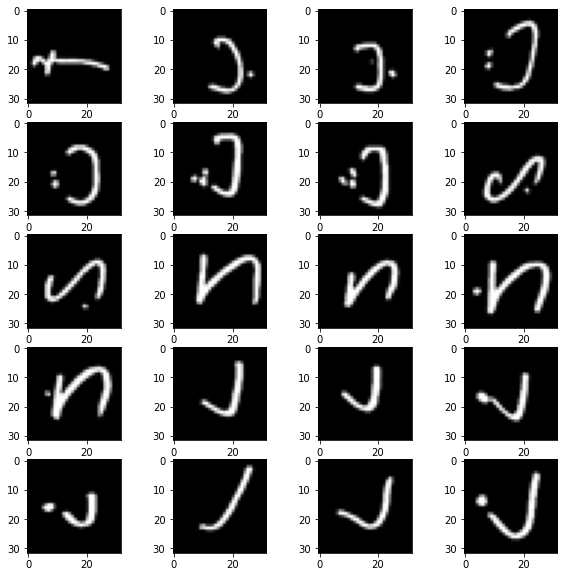

In [8]:
fig = plt.figure(figsize=(10, 10))                                              # Setting the figure size.
columns = 4                                                                     # Selecting the number of columns.
rows = 5                                                                        # Selectin the number of rows.
for i in range(1, columns*rows +1):                                             # Looping through rows & columns.
  img = test_data_x.iloc[i].to_numpy().reshape((32,32))                         # Reshaping the image into its size 32x32
  fig.add_subplot(rows, columns, i)                                             # Adding the image to the plot
  plt.imshow(img, cmap='gray')                                                  # Showing the image using plt
plt.show()                                                                      # Finally shpwing the whole plot containing all the subplots

5- Now we define a function for us to preprocess the data,

We will start with reshaping the image to be with the size of 32x32, so that the training array will be of size of #imagesx32x32, then we will pass through each image to flip and rotate them as they are rotated, then we will reshape the entire array with the #imagex32x32x1, and the 1 stands for our grey scale images, lastly we will normalize our images by dividing by 255 for pixels normalization.

In [9]:
def preprocess_data(train_data_x):
  train_data_x = train_data_x.to_numpy().reshape((train_data_x.shape[0], 32, 32)).astype('uint8') #convert every data to numpy and then reshape it to total_image, 32pxl, 32pxl
  for i in range(len(train_data_x)):                                            # iterate to every single of data
    train_data_x[i] = cv2.rotate(train_data_x[i], cv2.ROTATE_90_CLOCKWISE)      # Rotating the images.
    train_data_x[i] = np.flip(train_data_x[i], 1)                               # Flipping the images
  train_data_x = train_data_x.reshape([-1, 32, 32, 1]).astype('uint8')          # Reshaping into the required size.
  train_data_x = train_data_x.astype('float32')/255                             # Here we normalize our images.
  return np.asarray(train_data_x)

In [10]:
train_x = preprocess_data(train_data_x)                                         # Returns an array of dimensions (13440,32,32,1).
test_x = preprocess_data(test_data_x)                                           # Returns an array of dimensions (3360,32,32,1).

6- Now we preprocess our labels by converting them to the categorcal form.

Note: we subtracted one from the values of the labels we so get our classes values in the form of 0-27 as we mentioned earlier.

In [11]:
train_y = to_categorical(train_data_y.values.astype('int32') - 1                # Returns an array of dimentions (13340, 28).
                         , num_classes=28)
test_y = to_categorical(test_data_y.values.astype('int32') - 1                  # Returns an array of dimentions (3360, 28).
                        , num_classes=28)

In [12]:
train_y[120]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)

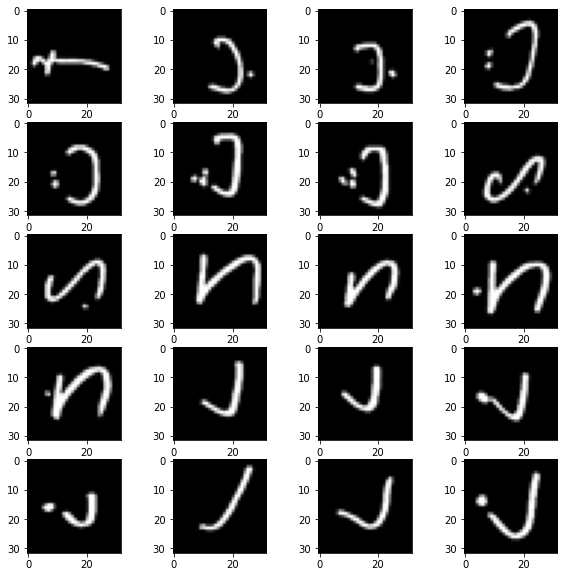

In [13]:
fig = plt.figure(figsize=(10, 10))                                              # Setting the figure size.
columns = 4                                                                     # Selecting the number of columns.
rows = 5                                                                        # Selectin the number of rows.
for i in range(1, columns*rows +1):                                             # Looping through rows & columns.
  img = test_data_x.iloc[i].to_numpy().reshape((32,32))                         # Reshaping the image into its size 32x32
  fig.add_subplot(rows, columns, i)                                             # Adding the image to the plot
  plt.imshow(img, cmap='gray')                                                  # Showing the image using plt
plt.show()                                                                      # Finally shpwing the whole plot containing all the subplots

7- We will now shuffle our training and test sets as we will get better results than using the data's classes in sequential form.

In [14]:
from sklearn.utils import shuffle                                               # Importing shuffle function from sklearn library.
train_x, train_y = shuffle(train_x, train_y)                                    # Now we shuffle x & y in the training set.
test_x, test_y, shuffle(test_x, test_y)                                         # Then x & y in our testing set.

(array([[[[0.],
          [0.],
          [0.],
          ...,
          [0.],
          [0.],
          [0.]],
 
         [[0.],
          [0.],
          [0.],
          ...,
          [0.],
          [0.],
          [0.]],
 
         [[0.],
          [0.],
          [0.],
          ...,
          [0.],
          [0.],
          [0.]],
 
         ...,
 
         [[0.],
          [0.],
          [0.],
          ...,
          [0.],
          [0.],
          [0.]],
 
         [[0.],
          [0.],
          [0.],
          ...,
          [0.],
          [0.],
          [0.]],
 
         [[0.],
          [0.],
          [0.],
          ...,
          [0.],
          [0.],
          [0.]]],
 
 
        [[[0.],
          [0.],
          [0.],
          ...,
          [0.],
          [0.],
          [0.]],
 
         [[0.],
          [0.],
          [0.],
          ...,
          [0.],
          [0.],
          [0.]],
 
         [[0.],
          [0.],
          [0.],
          ...,
      

## Building Model

8- Define CNN model, 

We will use tensorflow for the creation of our model, we will start by creating a function for use to create our model, we will set the activation, optimizer and our initializing method as variables for us to easly modifiy it in the hyper-parameter tuning phase.

We will start by creating our first convolutional layer and setting up the input shape, we will create additional pooling layer along with a batch normalization layer, then we will add three convolutional layers with the same structure but the the double size of filters each layer.

Then we will flatten our layer preparing it for the fully connected layers, we will use a small neurons numbered layer with a drop out layer, batch normalization and we will add an L2 regularizer so we will control the overfitting.

In [15]:
def create_model(activation='relu', optimizer='adam', kernel_initializer='he_normal'):
  model = tf.keras.models.Sequential([
      tf.keras.layers.Conv2D(32, (3,3), padding='same', input_shape=(32, 32, 1), activation= activation, kernel_initializer=kernel_initializer),
      tf.keras.layers.MaxPool2D(2,2),
      tf.keras.layers.BatchNormalization(),
      tf.keras.layers.Conv2D(64, (3,3), padding='same', activation= activation, kernel_initializer=kernel_initializer),
      tf.keras.layers.MaxPool2D(2,2),
      tf.keras.layers.Dropout(0.2),
      tf.keras.layers.BatchNormalization(),
      tf.keras.layers.Conv2D(128, (3,3), padding='same', activation= activation, kernel_initializer=kernel_initializer),
      tf.keras.layers.MaxPool2D(2,2),
      tf.keras.layers.Dropout(0.2),
      tf.keras.layers.BatchNormalization(),

      tf.keras.layers.Flatten(),
      
      tf.keras.layers.Dense(32, activation= activation, kernel_initializer=kernel_initializer, kernel_regularizer='l2'),
      tf.keras.layers.BatchNormalization(),
      tf.keras.layers.Dropout(0.2),
      tf.keras.layers.Dense(28, activation= 'softmax', kernel_initializer=kernel_initializer)
  ])

  model.compile(optimizer=optimizer,
                loss='categorical_crossentropy', #single output
                metrics=['accuracy'])
  return model

In [16]:
model = create_model()                                                          # Now we created an instance of a model with our custom architefture.
model.summary()                                                                 # Then we display our model's summary.

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 32)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 32)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 16, 16, 32)        128       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 16, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 8, 8, 64)          0         
_________________________________________________________________
dropout (Dropout)            (None, 8, 8, 64)          0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 8, 8, 64)          2

9- Let's start selecting the best hyperparamters for our model, we will do this by performing grid parameter tuning, which indicates performing all the possible combinations for our hyperparameters, then selecting the combination by selecting the best model.

In [17]:
seed = 7                                                                        # Select a fixed seed
np.random.seed(seed)                                                            # Specifing the seed for our random generator

optimizer = ['RMSprop', 'Adam', 'Adagrad', 'Nadam']                             # Available optimizers
kernel_initializer = ['normal', 'uniform']                                      # Available initializing methods
activation = ['relu', 'linear', 'tanh']                                         # Available activation functions

param_grid = dict(optimizer=optimizer,                                          # Creating the grid
                  kernel_initializer=kernel_initializer,
                  activation=activation)

parameters_number = 1
for x in param_grid:
  parameters_number = parameters_number * len(param_grid[x]) 
print("Number of different parameter combinations = {}".format(parameters_number))

Number of different parameter combinations = 24


In [18]:
epochs = 5                                                                      # Specifing the number of epochs for each combination
batch_size = 64                                                                 # Setting the batch size

# Here we will create our different models and run them for 5 epochs each.
for a,b,c in [(x,y,z) for x in optimizer for z in activation for y in kernel_initializer]:
    params = {'optimizer' : a , 'kernel_initializer' : b , 'activation' : c}
    print(params)
    curr_model = create_model(optimizer=a, kernel_initializer=b, activation=c)
    curr_model.fit(train_x, train_y, 
                    validation_split=0.3,
                    epochs=epochs, batch_size=batch_size, verbose=1)
    print("=============================================================================")

{'optimizer': 'RMSprop', 'kernel_initializer': 'normal', 'activation': 'relu'}
Epoch 1/5
147/147 [==============================] - 9s 21ms/step - loss: 3.9324 - accuracy: 0.2316 - val_loss: 4.1451 - val_accuracy: 0.0357
Epoch 2/5
147/147 [==============================] - 3s 20ms/step - loss: 1.7356 - accuracy: 0.6833 - val_loss: 3.8953 - val_accuracy: 0.0585
Epoch 3/5
147/147 [==============================] - 3s 22ms/step - loss: 0.8992 - accuracy: 0.8533 - val_loss: 4.0637 - val_accuracy: 0.0779
Epoch 4/5
147/147 [==============================] - 3s 22ms/step - loss: 0.5716 - accuracy: 0.9006 - val_loss: 1.7410 - val_accuracy: 0.4660
Epoch 5/5
147/147 [==============================] - 3s 22ms/step - loss: 0.4188 - accuracy: 0.9252 - val_loss: 0.6926 - val_accuracy: 0.8261
{'optimizer': 'RMSprop', 'kernel_initializer': 'uniform', 'activation': 'relu'}
Epoch 1/5
147/147 [==============================] - 5s 23ms/step - loss: 3.1366 - accuracy: 0.3077 - val_loss: 4.1034 - val_accura

10- After looping through all the combinations it was found that the best combination is:

 [RMS Prop, Normal Initialization, Relu Activation]

 Then lets use them to build our final model.

In [19]:
model = create_model(optimizer='RMSprop',                                       # We create our model with the specified hyper parameters
                     kernel_initializer='normal',
                     activation='relu')

In [20]:
from tensorflow.keras.callbacks import ModelCheckpoint  # We will import a call back to save the best epoch's weights

checkpointer = ModelCheckpoint(filepath='Saved Model Character/weights.hdf5', verbose=1, save_best_only=True)
history = model.fit(train_x,                                                    
                    train_y, 
                    validation_split= 0.3,                                      # The model will split the data into 30% of validation.
                    epochs=30,                                                  # We will run the model for 30 epochs
                    batch_size=64,                                              # We will have a batch size of 64
                    callbacks=[checkpointer])                                   # Finally we will use the imported callback

Epoch 1/30
147/147 [==============================] - 5s 20ms/step - loss: 3.8681 - accuracy: 0.2667 - val_loss: 4.3134 - val_accuracy: 0.0357

Epoch 00001: val_loss improved from inf to 4.31339, saving model to Saved Model Character\weights.hdf5
Epoch 2/30
147/147 [==============================] - 4s 24ms/step - loss: 1.6400 - accuracy: 0.7183 - val_loss: 4.7792 - val_accuracy: 0.0357

Epoch 00002: val_loss did not improve from 4.31339
Epoch 3/30
147/147 [==============================] - 3s 20ms/step - loss: 0.8462 - accuracy: 0.8709 - val_loss: 4.6279 - val_accuracy: 0.0357

Epoch 00003: val_loss did not improve from 4.31339
Epoch 4/30
147/147 [==============================] - 3s 21ms/step - loss: 0.5350 - accuracy: 0.9101 - val_loss: 1.9863 - val_accuracy: 0.3797

Epoch 00004: val_loss improved from 4.31339 to 1.98635, saving model to Saved Model Character\weights.hdf5
Epoch 5/30
147/147 [==============================] - 3s 21ms/step - loss: 0.3934 - accuracy: 0.9292 - val_loss:

11- Now lets load the best epoch's weights and then evaluate our model using the test set.

In [21]:
model.load_weights('Saved Model Character/weights.hdf5')                                              # Loading the best weights        
model.evaluate(test_x, test_y)                                                  # Evaluating our model

105/105 [==============================] - 1s 4ms/step - loss: 0.2241 - accuracy: 0.9610


[0.22412239015102386, 0.9610118865966797]

12- Lets plot our training journy to check the performance and verify that the model is not overfitting.

Text(0.5, 1.0, 'Training and validation loss')

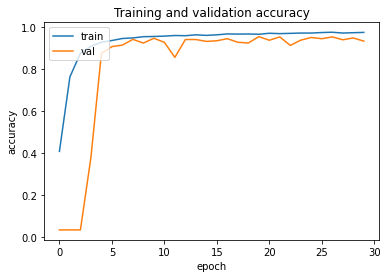

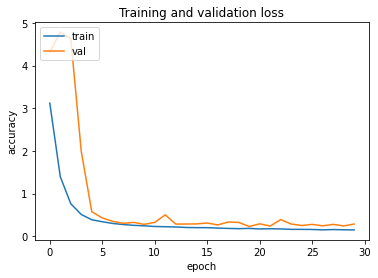

In [22]:
# PLOT LOSS AND ACCURACY
%matplotlib inline

import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs=range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Training and validation accuracy')
plt.legend(['train', 'val'], loc='upper left')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.figure()

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Training and validation loss')
plt.legend(['train', 'val'], loc='upper left')
plt.ylabel('accuracy')
plt.xlabel('epoch')


plt.title('Training and validation loss')


12- Lets save our model for later use

In [23]:
model.save('Saved Model Character/characters.h5')

##Testing Model

Now lets load our model and test it on our custom images.

In [1]:
import tensorflow as tf
model = tf.keras.models.load_model('Saved Model Character/characters.h5')                      # Now we load the model

TypeError: ('Keyword argument not understood:', 'groups')

In the following function we mapped the categorical output with the Arabic letters to help us better identifing the classes.

In [3]:
def convert_categorical_label_to_real_label(categorical_label):
  real_labels = []
  real_labels.extend(['أ', 'ب', 'ت', 'ث', 'ج', 'ح', 'خ', 'د', 'ذ', 'ر', 'ز', 'س', 'ش', 'ص', 'ض', 'ط', 'ظ', 'ع', 'غ', 'ف', 'ق', 'ك', 'ل', 'م', 'ن', 'ه', 'و', 'ى'])
  # print(real_labels)
  return real_labels[categorical_label]

Finally lets test them on custom images.

In [26]:
# for i in range(1, 4):
#   test = cv2.imread('z' + str(i) + '.png')
#   test = cv2.cvtColor(test, cv2.COLOR_BGR2GRAY)
#   test = cv2.resize(test, (32, 32))
#   plt.imshow(test, cmap='gray')
#   plt.show()
#   test = np.reshape(test, (-1, 32, 32, 1))
#   test = test.astype('float32')/255
#   print(convert_categorical_label_to_real_label(np.argmax(model.predict(test))))

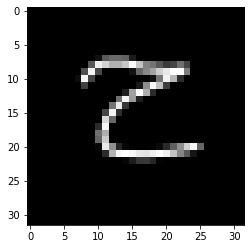

ح
(1, 32, 32, 1)


In [8]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
test = cv2.imread(r'D:\AtlantisSeeker-UIN\Skripsi Imam\Arabic char and digits recognition\Individual Model\Arabic Character Recognition\Dataset\handmade dataset\2022_01_21_0rt_Kleki.png')
test = cv2.cvtColor(test, cv2.COLOR_BGR2GRAY)
test = cv2.resize(test, (32, 32))
plt.imshow(test, cmap='gray')
plt.show()
test = np.reshape(test, (-1, 32, 32, 1))
test = test.astype('float32')/255
print(convert_categorical_label_to_real_label(np.argmax(model.predict(test))))
print(test.shape)

In [2]:
import tensorflow as tf
interpreter = tf.lite.Interpreter(r'D:\AtlantisSeeker-UIN\Skripsi Imam\Arabic char and digits recognition\Individual Model\Arabic Character Recognition\Saved Model Character\model_digit.tflite')

input_details = interpreter.get_input_details()
waveform_input_index = input_details[0]['index']
output_details = interpreter.get_output_details()
scores_output_index = output_details[0]['index']

In [3]:
print(output_details)

[{'name': 'Identity', 'index': 37, 'shape': array([ 1, 28]), 'shape_signature': array([-1, 28]), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}]


In [2]:
real_labels = []
real_labels.extend(['أ', 'ب', 'ت', 'ث', 'ج', 'ح', 'خ', 'د', 'ذ', 'ر', 'ز', 'س', 'ش', 'ص', 'ض', 'ط', 'ظ', 'ع', 'غ', 'ف', 'ق', 'ك', 'ل', 'م', 'ن', 'ه', 'و', 'ى'])

textfile = open(r"D:\AtlantisSeeker-UIN\Skripsi Imam\Arabic char and digits recognition\Individual Model\Arabic Character Recognition\label_char_only.txt", "w", encoding='utf-8')

for element in real_labels:
    textfile.write(element + "\n")
textfile.close()

In [29]:
import tensorflow as tf

# Convert the model.
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the model.
with open('D:\AtlantisSeeker-UIN\Skripsi Imam\Arabic char and digits recognition\Individual Model\Arabic Character Recognition\Saved Model Character\model_digit.tflite', 'wb') as f:
  f.write(tflite_model)

INFO:tensorflow:Assets written to: C:\Users\IMAMLU~1\AppData\Local\Temp\tmpiwwubhzy\assets


In [30]:
from tflite_support.metadata_writers import image_classifier
from tflite_support.metadata_writers import writer_utils

In [31]:
ImageClassifierWriter = image_classifier.MetadataWriter
_MODEL_PATH = "D:\AtlantisSeeker-UIN\Skripsi Imam\Arabic char and digits recognition\Individual Model\Arabic Character Recognition\Saved Model Character\model_digit.tflite"
# Task Library expects label files that are in the same format as the one below.
_LABEL_FILE = "D:\AtlantisSeeker-UIN\Skripsi Imam\Arabic char and digits recognition\Individual Model\Arabic Character Recognition\label_char_only.txt"
_SAVE_TO_PATH = "D:\AtlantisSeeker-UIN\Skripsi Imam\Arabic char and digits recognition\Individual Model\Arabic Character Recognition\Saved Model Character/model_digit_with_metadata.tflite"
# Normalization parameters is required when reprocessing the image. It is
# optional if the image pixel values are in range of [0, 255] and the input
# tensor is quantized to uint8. See the introduction for normalization and
# quantization parameters below for more details.
# https://www.tensorflow.org/lite/convert/metadata#normalization_and_quantization_parameters)
_INPUT_NORM_MEAN = 127.5
_INPUT_NORM_STD = 127.5

# Create the metadata writer.
writer = ImageClassifierWriter.create_for_inference(
    writer_utils.load_file(_MODEL_PATH), [_INPUT_NORM_MEAN], [_INPUT_NORM_STD],
    [_LABEL_FILE])

# Verify the metadata generated by metadata writer.
print(writer.get_metadata_json())

# Populate the metadata into the model.
writer_utils.save_file(writer.populate(), _SAVE_TO_PATH)

{
  "name": "ImageClassifier",
  "description": "Identify the most prominent object in the image from a known set of categories.",
  "subgraph_metadata": [
    {
      "input_tensor_metadata": [
        {
          "name": "image",
          "description": "Input image to be classified.",
          "content": {
            "content_properties_type": "ImageProperties",
            "content_properties": {
              "color_space": "RGB"
            }
          },
          "process_units": [
            {
              "options_type": "NormalizationOptions",
              "options": {
                "mean": [
                  127.5
                ],
                "std": [
                  127.5
                ]
              }
            }
          ],
          "stats": {
            "max": [
              1.0
            ],
            "min": [
              -1.0
            ]
          }
        }
      ],
      "output_tensor_metadata": [
        {
          "name": "proba